## Final Project

2021-05-18  
Casey Ellis  
Meenu Ravi  
Kentaro Hama  

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot
from pmdarima.arima import auto_arima
from sktime.forecasting.all import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller

## Load data

In [2]:
df = pd.read_csv("df.csv")
df.index = pd.date_range(min(df.ds), max(df.ds), freq = "MS")
ds = pd.DataFrame({'ds': pd.to_datetime(df["ds"])})
df['year'] = ds['ds'].dt.year 
df['month'] = ds['ds'].dt.month 
df_year = df.groupby("year").sum()

In [3]:
display(df.drop(['ds','year','month'],axis=1).head())

,yosemite,sequoia,kings,gasoline,temp
1979-01-01,72701,25338,19924,0.716,40.2
1979-02-01,72926,22334,18242,0.730,42.6
1979-03-01,87950,24271,18114,0.755,48.3
1979-04-01,136275,47410,37101,0.802,52.3
1979-05-01,210756,63854,63777,0.844,62.6


## Part 1. EDA

## Number of visitors by year and by park

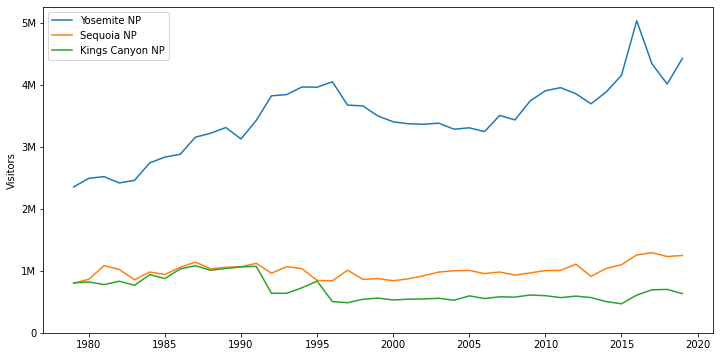

In [4]:
df_year[["yosemite","sequoia","kings"]].plot(figsize=[12,6])
plt.ylabel("Visitors")
plt.xlabel("")
plt.legend(["Yosemite NP", "Sequoia NP", "Kings Canyon NP"])
plt.yticks([0, 1000000, 2000000, 3000000, 4000000 , 5000000], ["0", "1M", "2M", "3M", "4M" , "5M"])
plt.show()

## Number of visitors by month and by park

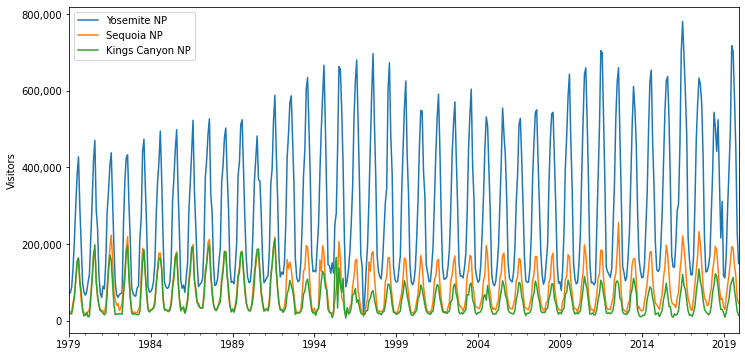

In [5]:
df[["yosemite","sequoia","kings"]].plot(figsize=[12,6])
plt.ylabel("Visitors")
plt.yticks([0, 200000, 400000, 600000, 800000], ["0", "200,000", "400,000", "600,000", "800,000"])
plt.legend(["Yosemite NP", "Sequoia NP", "Kings Canyon NP"])
plt.show()

## Seasonal subseries plot

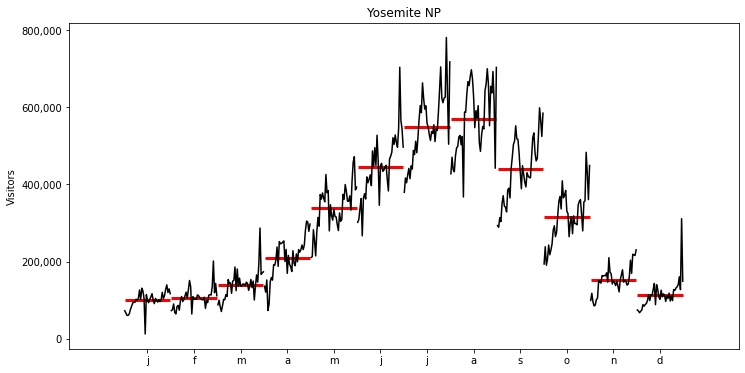

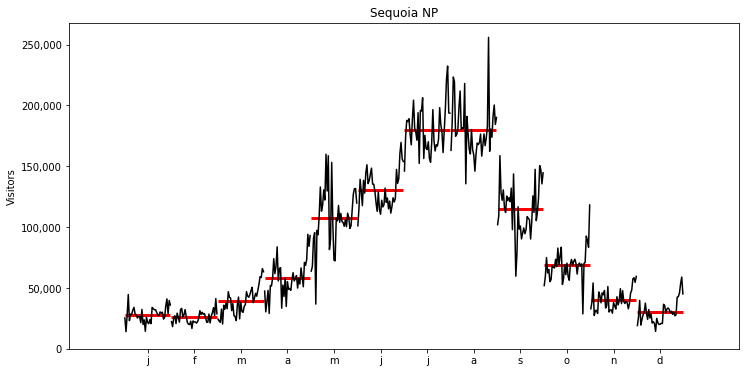

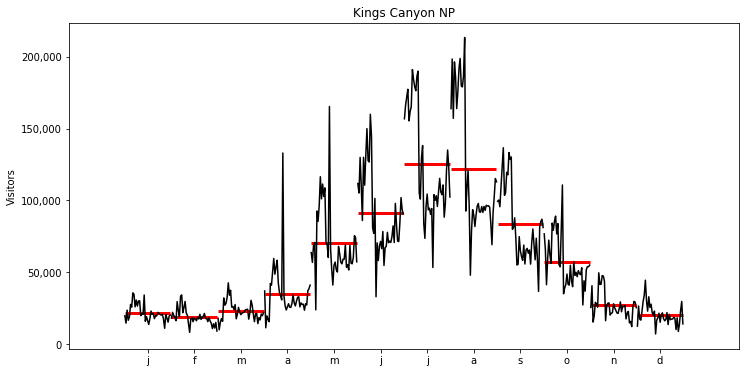

In [6]:
plt.rc("figure", figsize = [12,6])
month_plot(df['yosemite'], ylabel = "Visitors")
plt.title("Yosemite NP")
plt.yticks([0, 200000, 400000, 600000, 800000], ["0", "200,000", "400,000", "600,000", "800,000"])
plt.show()

plt.rc("figure", figsize = [12,6])
month_plot(df['sequoia'], ylabel = "Visitors")
plt.title("Sequoia NP")
plt.yticks([0, 50000, 100000, 150000, 200000, 250000], ["0", "50,000", "100,000", "150,000", "200,000","250,000"])
plt.show()

plt.rc("figure", figsize = [12,6])
month_plot(df['kings'], ylabel = "Visitors")
plt.title("Kings Canyon NP")
plt.yticks([0, 50000, 100000, 150000, 200000], ["0", "50,000", "100,000", "150,000", "200,000"])
plt.show()

## Trends in other exogenous variables

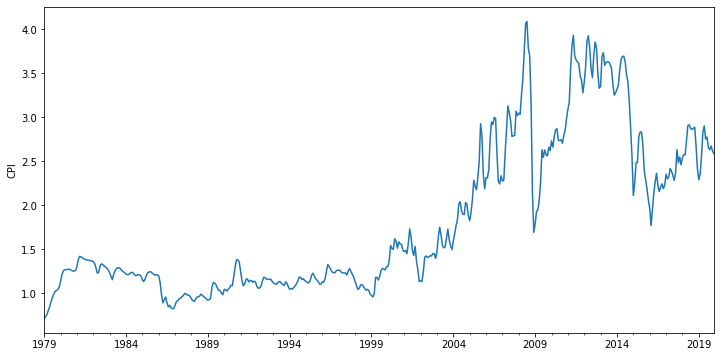

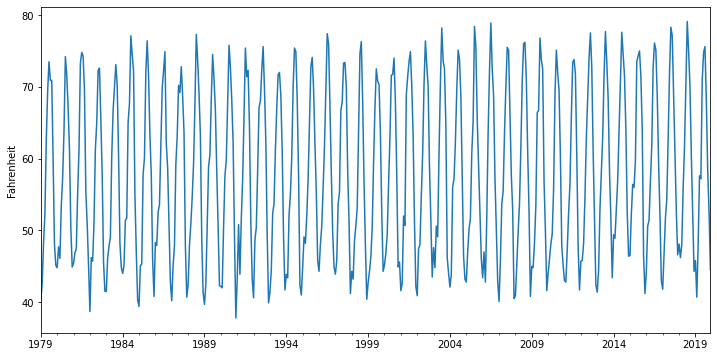

In [7]:
plt.figure(figsize=[12,6])
df["gasoline"].plot()
plt.ylabel("CPI")
plt.show()

plt.figure(figsize=[12,6])
df["temp"].plot()
plt.ylabel("Fahrenheit")
plt.show()

### Seasonal adjustment and differencing, and seasonality check

In [8]:
df["yosemite_seasdiff"] = df["yosemite"].diff(12)
df["sequoia_seasdiff"] = df["sequoia"].diff(12)
df["kings_seasdiff"] = df["kings"].diff(12)
df["gasoline_seasdiff"] = df["gasoline"].diff(12)
df["temp_seasdiff"] = df["temp"].diff(12)
df_diff = df.dropna()

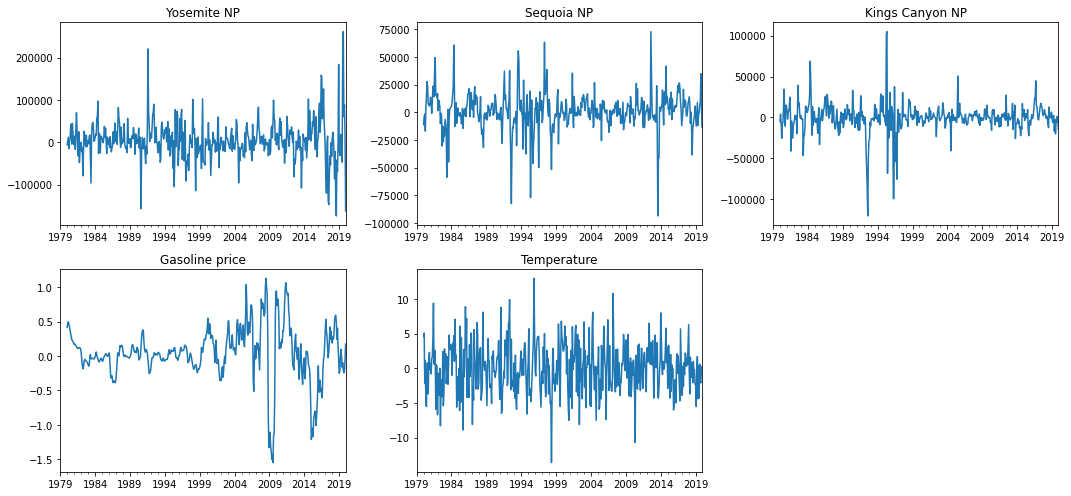

In [9]:
fig = plt.figure(figsize=[15,7])
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)

df["yosemite_seasdiff"].plot(ax = ax1)
df["sequoia_seasdiff"].plot(ax = ax2)
df["kings_seasdiff"].plot(ax = ax3)
df["gasoline_seasdiff"].plot(ax = ax4)
df["temp_seasdiff"].plot(ax = ax5)

ax1.set_title("Yosemite NP")
ax2.set_title("Sequoia NP")
ax3.set_title("Kings Canyon NP")
ax4.set_title("Gasoline price")
ax5.set_title("Temperature")

fig.tight_layout()
plt.show()

In [10]:
import warnings
warnings.filterwarnings('ignore')

def adf_kpss_test(timeseries, trend = "c"):
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test")
    print("-----------------------------")
    result = adfuller(timeseries, autolag = "AIC")
    print("Test Statistic: %.3f" % result[0])
    print("p-value: %.3f" % result[1])
    print("Lags Used: %.f" % result[2])
    print("Number of Observations Used: %.f" % result[3])
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t%s: %.3f" % (key, value))
    if result[1] < 0.05:
        print("Interpret: Stationary")
    else:
        print("Interpret: Non-stationary")
 
    print("")

    #Perform KPSS test:
    print("Results of KPSS Test")
    print("-----------------------------")
    result = kpss(timeseries, regression = trend)
    print("Test Statistic: %.3f" % result[0])
    print("p-value: %.3f" % result[1])
    print("Lags Used: %.f" % result[2])
    print("Critical Values:")
    for key, value in result[3].items():
        print("\t%s: %.3f" % (key, value))
    if result[1] > 0.05:
        print("Interpret: Stationary")
    else:
        print("Interpret: Non-stationary")

In [11]:
adf_kpss_test(df["yosemite_seasdiff"].dropna())

Results of Dickey-Fuller Test
-----------------------------
Test Statistic: -5.837
p-value: 0.000
Lags Used: 12
Number of Observations Used: 467
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Interpret: Stationary

Results of KPSS Test
-----------------------------
Test Statistic: 0.069
p-value: 0.100
Lags Used: 18
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Interpret: Stationary


In [12]:
adf_kpss_test(df["sequoia_seasdiff"].dropna())

Results of Dickey-Fuller Test
-----------------------------
Test Statistic: -6.151
p-value: 0.000
Lags Used: 14
Number of Observations Used: 465
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Interpret: Stationary

Results of KPSS Test
-----------------------------
Test Statistic: 0.065
p-value: 0.100
Lags Used: 18
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Interpret: Stationary


In [13]:
adf_kpss_test(df["kings_seasdiff"].dropna())

Results of Dickey-Fuller Test
-----------------------------
Test Statistic: -5.938
p-value: 0.000
Lags Used: 12
Number of Observations Used: 467
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Interpret: Stationary

Results of KPSS Test
-----------------------------
Test Statistic: 0.062
p-value: 0.100
Lags Used: 18
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Interpret: Stationary


In [14]:
adf_kpss_test(df["gasoline_seasdiff"].dropna())

Results of Dickey-Fuller Test
-----------------------------
Test Statistic: -4.648
p-value: 0.000
Lags Used: 17
Number of Observations Used: 462
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
Interpret: Stationary

Results of KPSS Test
-----------------------------
Test Statistic: 0.075
p-value: 0.100
Lags Used: 18
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Interpret: Stationary


In [15]:
adf_kpss_test(df["temp_seasdiff"].dropna())

Results of Dickey-Fuller Test
-----------------------------
Test Statistic: -8.394
p-value: 0.000
Lags Used: 12
Number of Observations Used: 467
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Interpret: Stationary

Results of KPSS Test
-----------------------------
Test Statistic: 0.025
p-value: 0.100
Lags Used: 18
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Interpret: Stationary


## Correlation between seasonal adjusted variables

,yosemite_seasdiff,sequoia_seasdiff,kings_seasdiff,gasoline_seasdiff,temp_seasdiff
yosemite_seasdiff,1.00,0.27,0.10,-0.18,0.14
sequoia_seasdiff,0.27,1.00,0.24,-0.07,0.14
kings_seasdiff,0.10,0.24,1.00,-0.06,0.06
gasoline_seasdiff,-0.18,-0.07,-0.06,1.00,0.03
temp_seasdiff,0.14,0.14,0.06,0.03,1.00


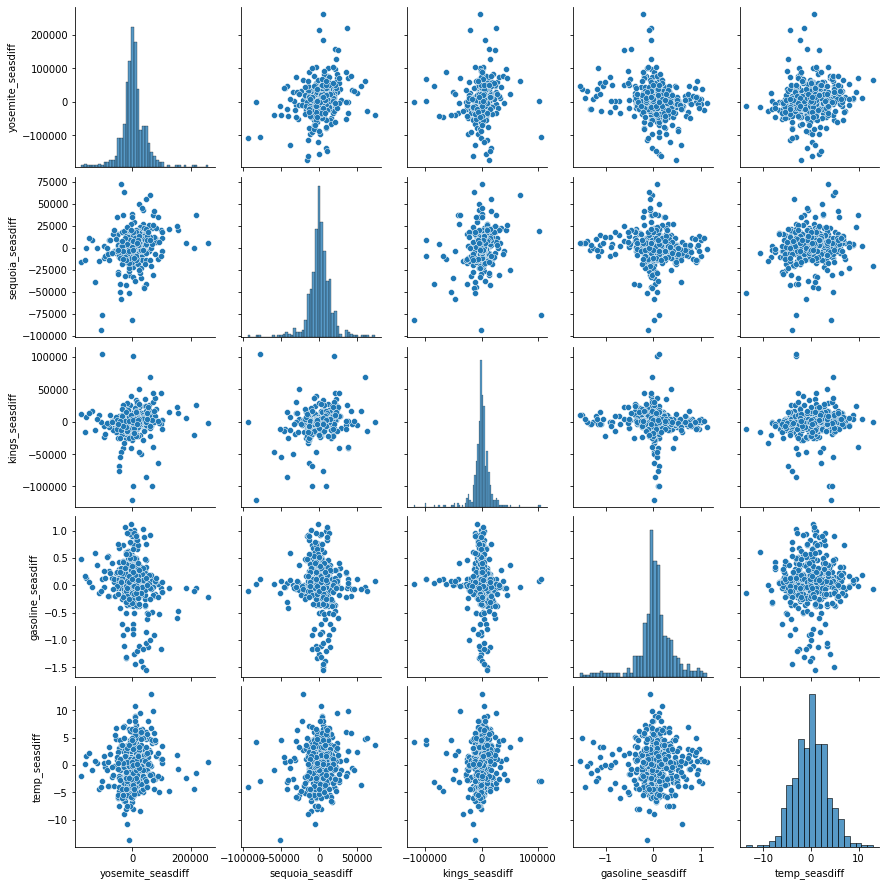

In [16]:
display(round(df[['yosemite_seasdiff','sequoia_seasdiff','kings_seasdiff','gasoline_seasdiff','temp_seasdiff']].corr(), 2))
sns.pairplot(df[['yosemite_seasdiff','sequoia_seasdiff','kings_seasdiff','gasoline_seasdiff','temp_seasdiff']])
plt.show()

## Part 2. SARIMAX

### Search for SARIMAX orders - Sequoia

In [17]:
y_train, y_test = temporal_train_test_split(df_diff)

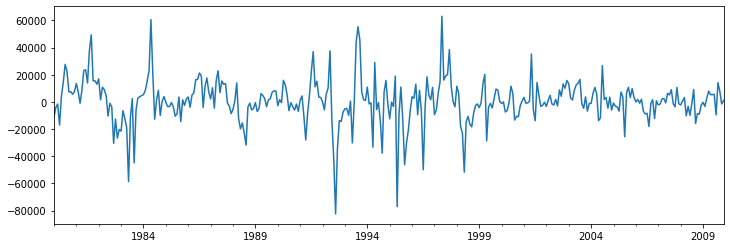

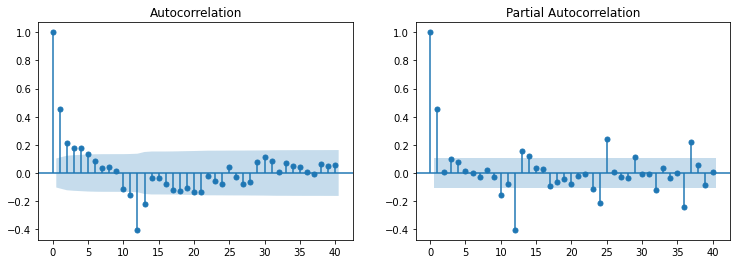

In [18]:
y_train["sequoia_seasdiff"].plot(figsize = [12,4])
plt.show()

fig = plt.figure(figsize = [12.4,4])
ax1 = fig.add_subplot(1,2,1)
fig = plot_acf(y_train["sequoia_seasdiff"].dropna(), lags = 40, ax = ax1)
ax2 = fig.add_subplot(1,2,2)
fig = plot_pacf(y_train["sequoia_seasdiff"].dropna(), lags = 40, ax = ax2)

For Sequoia NP, the significant spike at lag 4 in the ACF suggests a non-seasonal MA(4) component. The significant spike at lag 12 in the ACF suggests a seasonal MA(1) component. On the other hand, the seasonal lag of the PACF is decaying. Consequently, we begin with an SARIMAX(0,0,4)(0,1,1)12 model.

### Search for SARIMAX orders - Kings Canyon

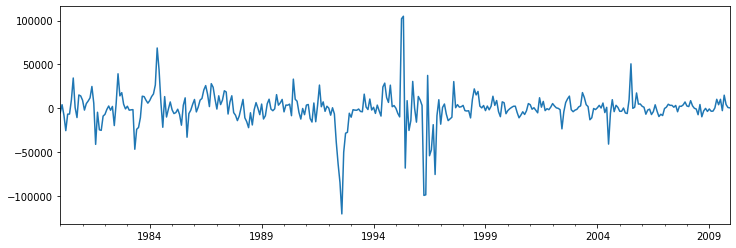

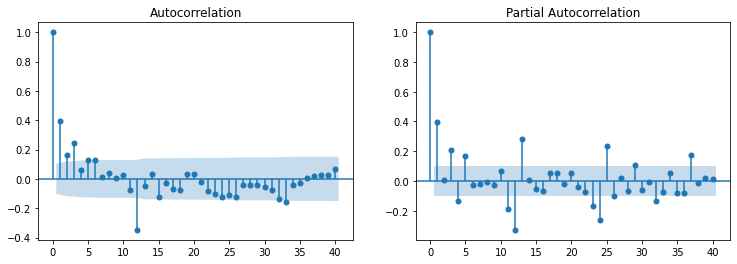

In [19]:
y_train["kings_seasdiff"].plot(figsize = [12,4])
plt.show()

fig = plt.figure(figsize = [12.4,4])
ax1 = fig.add_subplot(1,2,1)
fig = plot_acf(y_train["kings_seasdiff"].dropna(), lags = 40, ax = ax1)
ax2 = fig.add_subplot(1,2,2)
fig = plot_pacf(y_train["kings_seasdiff"].dropna(), lags = 40, ax = ax2)

For Kings NP, the significant spike at lag 3 in the ACF suggests a non-seasonal MA(3) component. The significant spike at lag 12 in the ACF suggests a seasonal MA(1) component. On the other hand, the seasonal lag of the PACF is decaying. Consequently, we begin with an SARIMA(0,0,3)(0,1,1)12 model.

### Fit SARIMAX - Sequoia

In [20]:
sequoia_exog_train = y_train[["yosemite_seasdiff","kings_seasdiff","gasoline_seasdiff","temp_seasdiff"]]
sequoia_exog_test = y_test[["yosemite_seasdiff","kings_seasdiff","gasoline_seasdiff","temp_seasdiff"]]

In [21]:
sequoia_sarimax_model = sm.tsa.statespace.SARIMAX(endog = y_train["sequoia"], 
                                                  exog = sequoia_exog_train,
                                                  order=(0,0,4), seasonal_order=(0,1,1,12))
sequoia_sarimax_model_fit = sequoia_sarimax_model.fit()
print(sequoia_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              sequoia   No. Observations:                  360
Model:             SARIMAX(0, 0, 4)x(0, 1, [1], 12)   Log Likelihood               -3791.574
Date:                              Wed, 19 May 2021   AIC                           7603.147
Time:                                      15:22:17   BIC                           7641.669
Sample:                                  01-01-1980   HQIC                          7618.484
                                       - 12-01-2009                                         
Covariance Type:                                opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
yosemite_seasdiff     0.0688      0.016      4.209      0.000       0.037       0.10

### Fit SARIMAX - Kings Canyon

In [22]:
kings_exog_train = y_train[["yosemite_seasdiff","sequoia_seasdiff","gasoline_seasdiff","temp_seasdiff"]]
kings_exog_test = y_test[["yosemite_seasdiff","sequoia_seasdiff","gasoline_seasdiff","temp_seasdiff"]]

In [23]:
kings_sarimax_model = sm.tsa.statespace.SARIMAX(endog = y_train["kings"], 
                                                exog = kings_exog_train,
                                                order=(0,0,3), seasonal_order=(0,1,1,12))
kings_sarimax_model_fit = kings_sarimax_model.fit()
print(kings_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                kings   No. Observations:                  360
Model:             SARIMAX(0, 0, 3)x(0, 1, [1], 12)   Log Likelihood               -3855.192
Date:                              Wed, 19 May 2021   AIC                           7728.385
Time:                                      15:22:23   BIC                           7763.054
Sample:                                  01-01-1980   HQIC                          7742.187
                                       - 12-01-2009                                         
Covariance Type:                                opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
yosemite_seasdiff     0.0540      0.027      2.004      0.045       0.001       0.10

### Residual diagnosis - Sequoia

In [24]:
def examine_resid(residuals, lags = [12]):
    residuals.plot()
    plt.show()
    sns.distplot(residuals)
    p = plot_acf(residuals, lags=40, title='Autocorrelation Plot')
    display(sm.stats.acorr_ljungbox(residuals, lags=lags, return_df=True, boxpierce = True))

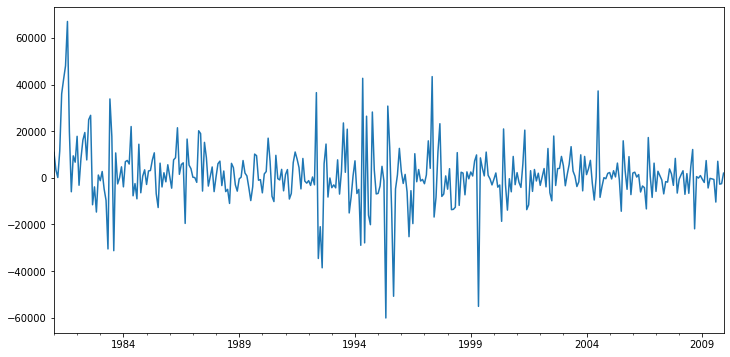

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,16.067196,0.188178,15.689377,0.205881


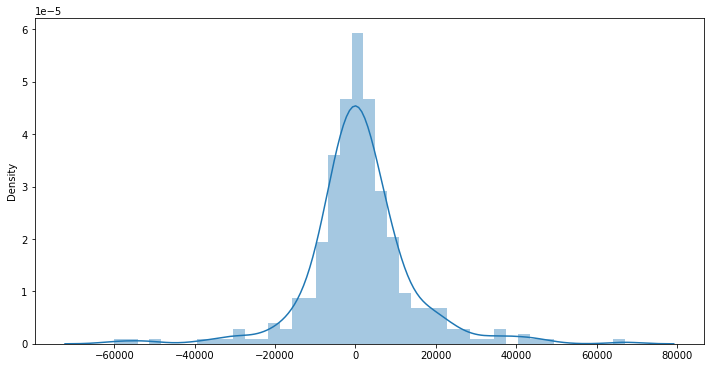

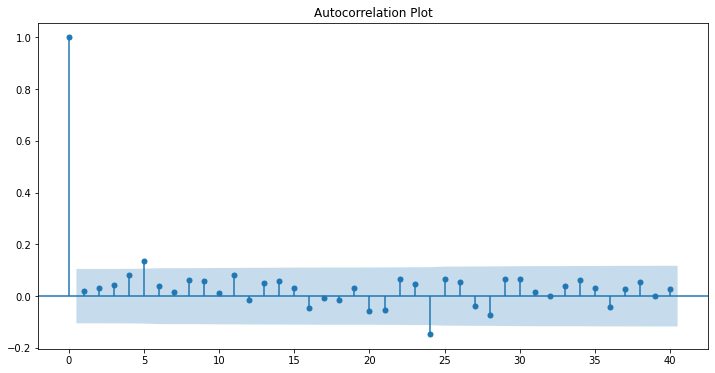

In [25]:
resid = sequoia_sarimax_model_fit.resid[12:]
examine_resid(resid)

### Residual diagnosis - Kings Canyon

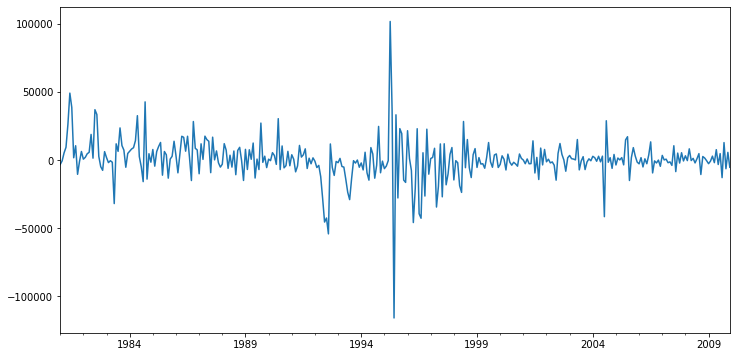

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,19.794268,0.071079,19.272155,0.082169


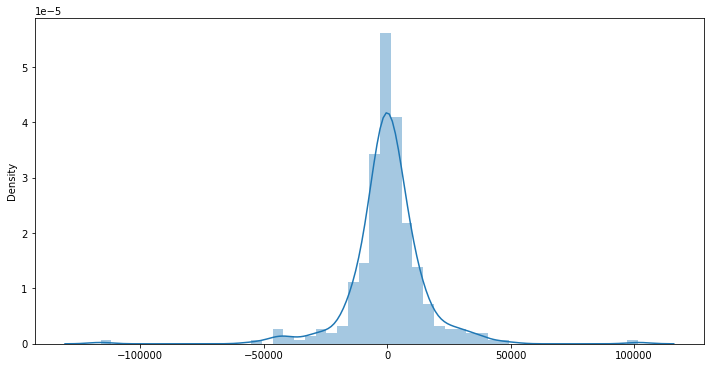

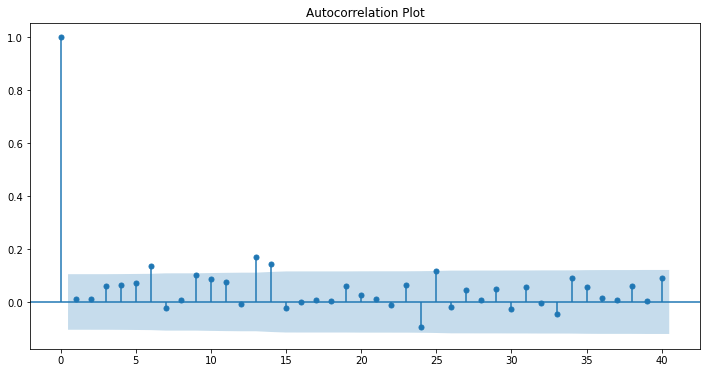

In [26]:
resid = kings_sarimax_model_fit.resid[12:]
examine_resid(resid)

There is no clear pattern in the distribution of residuals. The distribution is too sharp to be called a normal distribution, but it is not a strange distribution. The coefficients of ACF are generally not statistically significant. The results of portmanteau tests indicate that the null hypothesis that the residuals are not autocorrelated is not rejected. Therefore, it seems that the residuals are random.

### SARIMAX prediction results

In [27]:
sequoia_pred = sequoia_sarimax_model_fit.predict(
    start = min(y_test["ds"]), end = max(y_test["ds"]), 
    exog = sequoia_exog_test)
sequoia_pred.index = y_test.index

kings_pred = kings_sarimax_model_fit.predict(
    start = min(y_test["ds"]), end = max(y_test["ds"]), 
    exog = kings_exog_test)
kings_pred.index = y_test.index

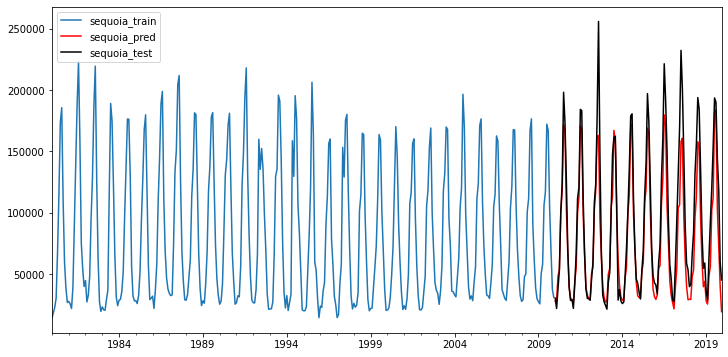

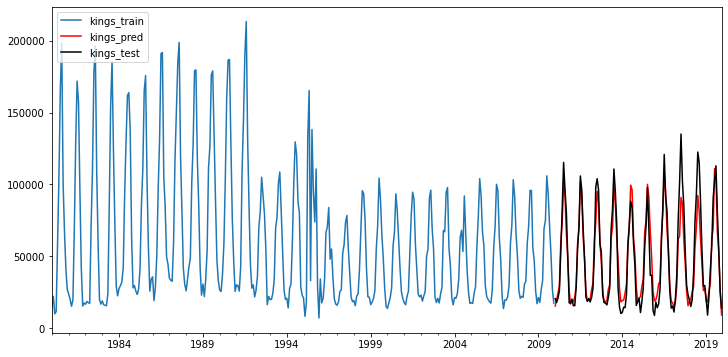

In [28]:
plt.figure(figsize=[12,6])
y_train["sequoia"].plot()
sequoia_pred.plot(color='red')
y_test["sequoia"].plot(color = 'black')
plt.xlabel("")
plt.legend(["sequoia_train", "sequoia_pred", "sequoia_test"], loc = "upper left")
plt.show()

plt.figure(figsize=[12,6])
y_train["kings"].plot()
kings_pred.plot(color='red')
y_test["kings"].plot(color = 'black')
plt.xlabel("")
plt.legend(["kings_train", "kings_pred", "kings_test"], loc = "upper left")
plt.show()

### Models' performance on test set

In [29]:
def mape_loss(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def MASE(y_train, y_test, y_pred):
    n = y_train.shape[0]
    d = np.abs(np.diff(y_train) ).sum()/(n-1)  
    errors = np.abs(y_test - y_pred)
    return errors.mean()/d

def model_eval(y_train, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mape_loss(y_test, y_pred)
    smape = smape_loss(y_test, y_pred)
    mase = MASE(y_train, y_test, y_pred)
    print(f'mae: {mae}')
    print(f'mse: {mse}')
    print(f'mape: {mape}')
    print(f'smape: {smape}')
    print(f'mase: {mase}')  

In [30]:
model_eval(y_train["sequoia"], y_test["sequoia"], sequoia_pred)

mae: 16025.81181423288
mse: 527155771.5240628
mape: 17.414197609566536
smape: 0.19103066791615667
mase: 0.5888903192992523


In [31]:
model_eval(y_train["kings"], y_test["kings"], kings_pred)

mae: 8416.705037330867
mse: 136249669.33904755
mape: 23.07938064480152
smape: 0.20278439066699355
mase: 0.39893141681676314


## Part 3. Auto SARIMAX

### Auto SARIMAX - Sequoia

In [32]:
sequoia_auto_model = auto_arima(y_train["sequoia"], exogenous=sequoia_exog_train,
                                start_p = 0, start_q = 4,
                                max_p = 5, max_q = 5, m = 12,
                                start_P = 0, start_Q = 1, seasonal = True,
                                d = 0, D = 1, trace = True,
                                error_action = 'ignore',
                                suppress_warnings = True,
                                stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,4)(0,1,1)[12] intercept   : AIC=7605.948, Time=1.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7703.184, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7619.369, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=7631.946, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9390.830, Time=0.06 sec
 ARIMA(0,0,4)(0,1,0)[12] intercept   : AIC=7637.394, Time=0.49 sec
 ARIMA(0,0,4)(1,1,1)[12] intercept   : AIC=7596.199, Time=1.54 sec
 ARIMA(0,0,4)(1,1,0)[12] intercept   : AIC=7621.251, Time=0.68 sec
 ARIMA(0,0,4)(2,1,1)[12] intercept   : AIC=7595.086, Time=3.57 sec
 ARIMA(0,0,4)(2,1,0)[12] intercept   : AIC=7607.886, Time=2.30 sec
 ARIMA(0,0,4)(2,1,2)[12] intercept   : AIC=7596.113, Time=9.56 sec
 ARIMA(0,0,4)(1,1,2)[12] intercept   : AIC=7595.949, Time=3.95 sec
 ARIMA(0,0,3)(2,1,1)[12] intercept   : AIC=7599.543, Time=2.25 sec
 ARIMA(1,0,4)(2,1,1)[12] intercept   : AIC=7590.513, Time=4.50 sec
 ARIMA(1,0,4)(1,1,1

In [33]:
sequoia_auto_model_fit = sequoia_auto_model.fit(y_train["sequoia"], exogenous = sequoia_exog_train)
print(sequoia_auto_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  360
Model:             SARIMAX(2, 0, 2)x(0, 1, 2, 12)   Log Likelihood               -3774.757
Date:                            Wed, 19 May 2021   AIC                           7571.514
Time:                                    15:27:39   BIC                           7613.888
Sample:                                01-01-1980   HQIC                          7588.384
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
yosemite_seasdiff     0.0617      0.019      3.225      0.001       0.024       0.099
kings_seasdiff

### Residuals diagnosis - Sequoia

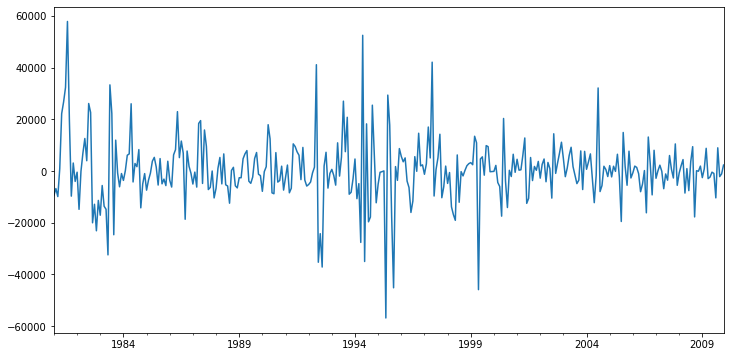

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,10.208639,0.597663,9.884237,0.626116


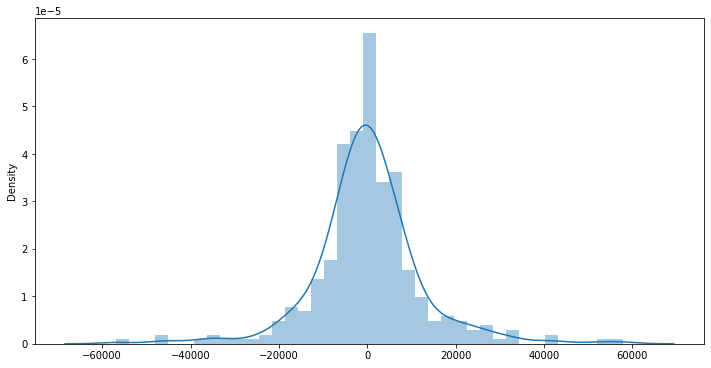

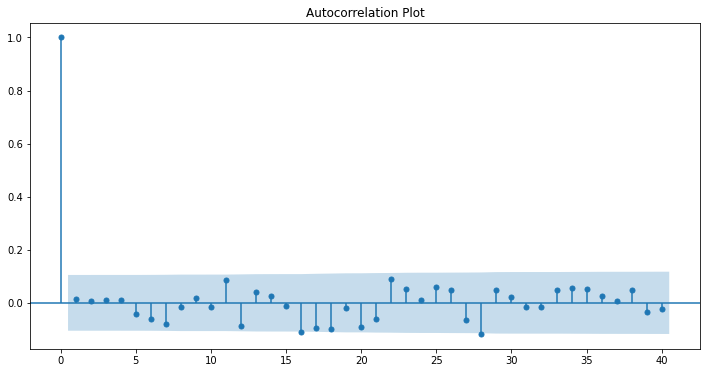

In [34]:
resid = pd.Series(sequoia_auto_model_fit.resid(), index = y_train.index)
resid = resid[12:]
examine_resid(resid)

### Auto SARIMAX - Kings

In [35]:
kings_auto_model = auto_arima(y_train["kings"], exogenous=kings_exog_train,
                              start_p = 0, start_q = 3,
                              max_p = 5, max_q = 5, m = 12,
                              start_P = 0, start_Q = 1, seasonal = True,
                              d = 0, D = 1, trace = True,
                              error_action = 'ignore',
                              suppress_warnings = True,
                              stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,3)(0,1,1)[12] intercept   : AIC=7730.549, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7869.889, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7764.664, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=7760.470, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9557.885, Time=0.07 sec
 ARIMA(0,0,3)(0,1,0)[12] intercept   : AIC=7796.187, Time=0.30 sec
 ARIMA(0,0,3)(1,1,1)[12] intercept   : AIC=7731.469, Time=0.82 sec
 ARIMA(0,0,3)(0,1,2)[12] intercept   : AIC=7731.289, Time=2.00 sec
 ARIMA(0,0,3)(1,1,0)[12] intercept   : AIC=7754.341, Time=0.50 sec
 ARIMA(0,0,3)(1,1,2)[12] intercept   : AIC=7733.182, Time=2.88 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=7758.608, Time=0.68 sec
 ARIMA(1,0,3)(0,1,1)[12] intercept   : AIC=7731.452, Time=1.28 sec
 ARIMA(0,0,4)(0,1,1)[12] intercept   : AIC=7733.129, Time=0.90 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=7740.251, Time=0.87 sec
 ARIMA(1,0,4)(0,1,1

In [36]:
kings_auto_model_fit = kings_auto_model.fit(y_train["kings"], exogenous = kings_exog_train)
print(kings_auto_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  360
Model:             SARIMAX(5, 0, 5)x(0, 1, [1, 2], 12)   Log Likelihood               -3839.782
Date:                                 Wed, 19 May 2021   AIC                           7713.564
Time:                                         15:33:40   BIC                           7779.052
Sample:                                     01-01-1980   HQIC                          7739.636
                                          - 12-01-2009                                         
Covariance Type:                                   opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
yosemite_seasdiff     0.0506      0.033      1.511      0.13

### Residual diagnosis - Kings

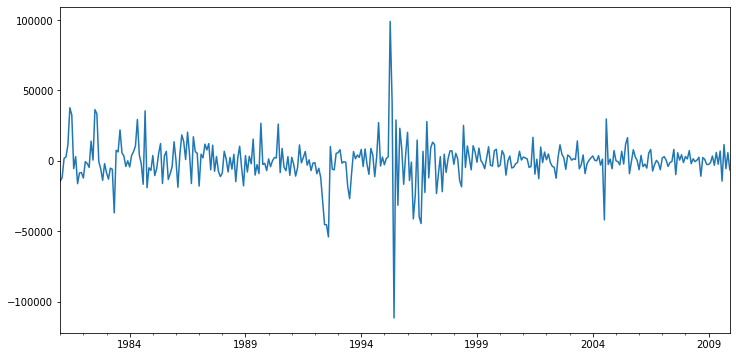

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,8.432232,0.750507,8.181838,0.770764


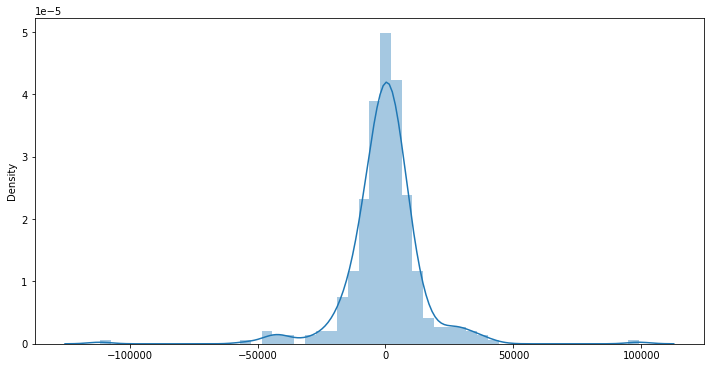

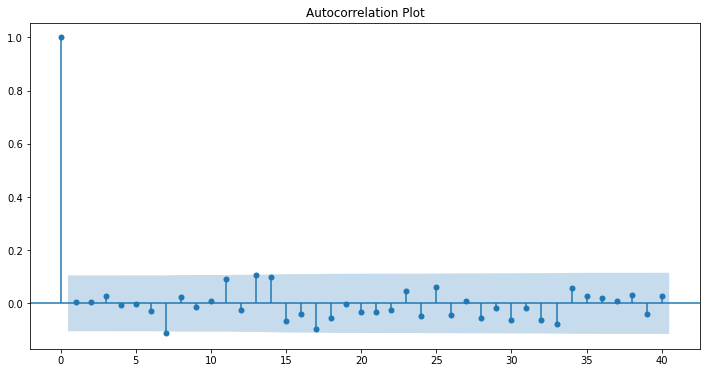

In [37]:
resid = pd.Series(kings_auto_model_fit.resid(), index = y_train.index)
resid = resid[12:]
examine_resid(resid)

### Auto SARIMAX prediction results

In [38]:
sequoia_auto_pred = pd.Series(sequoia_auto_model_fit.predict(len(y_test), exogenous = sequoia_exog_test))
sequoia_auto_pred.index = y_test.index

kings_auto_pred = pd.Series(kings_auto_model_fit.predict(len(y_test), exogenous = kings_exog_test))
kings_auto_pred.index = y_test.index

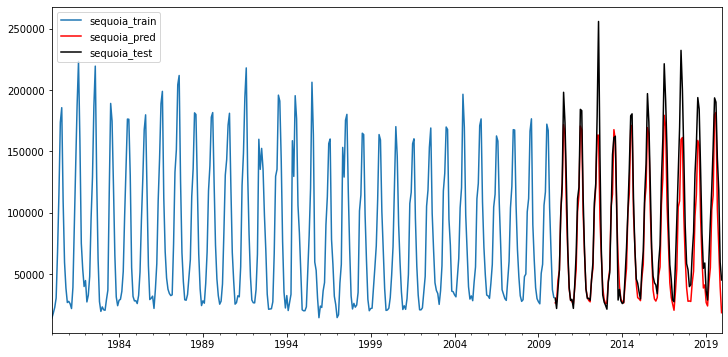

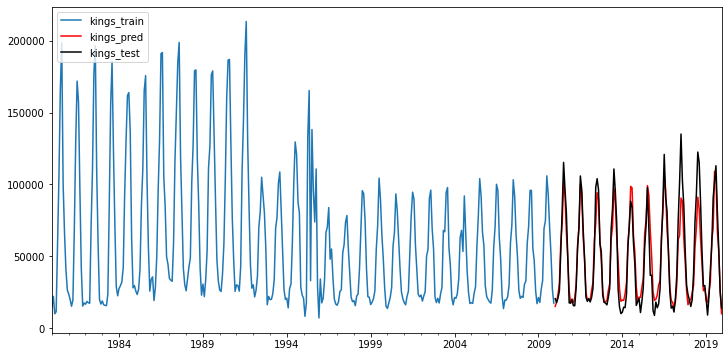

In [39]:
plt.figure(figsize=[12,6])
y_train["sequoia"].plot()
sequoia_auto_pred.plot(color='red')
y_test["sequoia"].plot(color = 'black')
plt.xlabel("")
plt.legend(["sequoia_train", "sequoia_pred", "sequoia_test"], loc = "upper left")
plt.show()

plt.figure(figsize=[12,6])
y_train["kings"].plot()
kings_auto_pred.plot(color='red')
y_test["kings"].plot(color = 'black')
plt.xlabel("")
plt.legend(["kings_train", "kings_pred", "kings_test"], loc = "upper left")
plt.show()

### Models' performance on test set

In [40]:
model_eval(y_train["sequoia"], y_test["sequoia"], sequoia_auto_pred)

mae: 16175.035619268667
mse: 524275565.83853114
mape: 17.764783726198676
smape: 0.1981226951282188
mase: 0.5943737516029144


In [41]:
model_eval(y_train["kings"], y_test["kings"], kings_auto_pred)

mae: 8319.78387747861
mse: 134778362.33389717
mape: 22.75444136074616
smape: 0.1992862256278936
mase: 0.3943375887750421


## Part 4. VARMAX

In [113]:
results_bic = []
orders = []

for (p,q) in [(p,q) for p in range(0,4) for q in range(0,4)]:
    if not p + q == 0:
        model =  VARMAX(y_train[['yosemite_seasdiff','sequoia_seasdiff','kings_seasdiff']], 
                        order=(p, q), 
                        exog=y_train[['gasoline_seasdiff','temp_seasdiff']])
        results = model.fit(disp=False)
        results_bic.append(results.bic)
        orders.append([p,q])

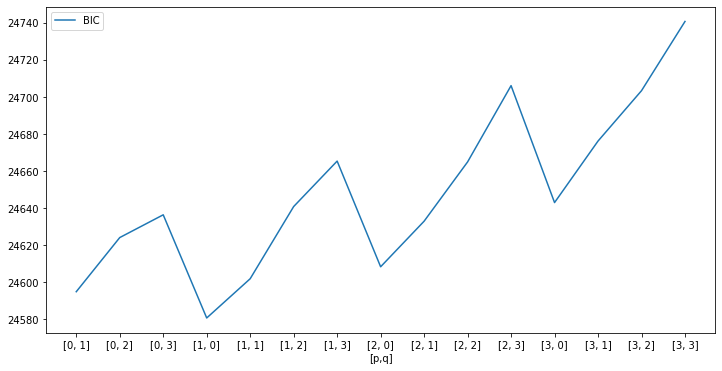

In [128]:
results = pd.DataFrame({'order': orders, 'BIC': results_bic})
results.plot()
plt.xticks(range(0,len(orders),1),orders)
plt.xlabel('[p,q]')
plt.show()

In [115]:
varmax_model =  VARMAX(y_train[['yosemite_seasdiff','sequoia_seasdiff','kings_seasdiff']], 
                       order=(1, 0), 
                       exog=y_train[['gasoline_seasdiff','temp_seasdiff']])
varmax_model_fit = varmax_model.fit(disp=False)
print(varmax_model_fit.summary())

                                                Statespace Model Results                                               
Dep. Variable:     ['yosemite_seasdiff', 'sequoia_seasdiff', 'kings_seasdiff']   No. Observations:                  360
Model:                                                                 VARX(1)   Log Likelihood              -12219.763
                                                                   + intercept   AIC                          24487.526
Date:                                                         Wed, 19 May 2021   BIC                          24580.792
Time:                                                                 16:09:41   HQIC                         24524.610
Sample:                                                             01-01-1980                                         
                                                                  - 12-01-2009                                         
Covariance Type:                        

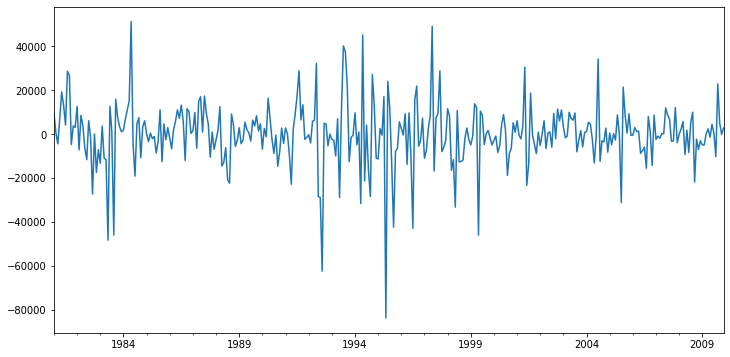

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,67.267042,1.035801e-09,64.752406,3.029185e-09


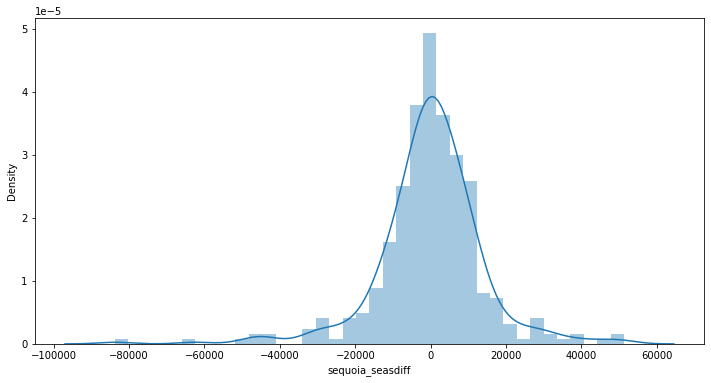

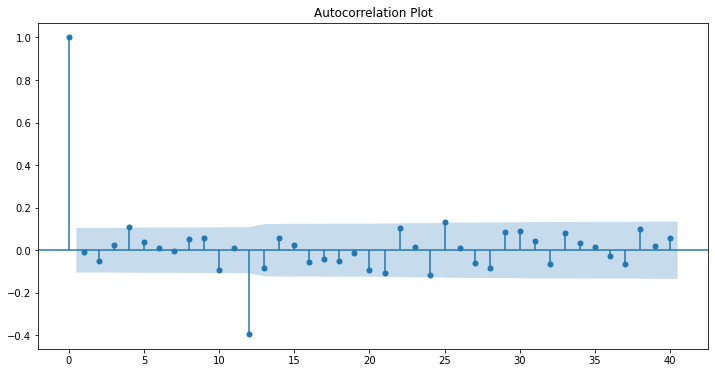

In [116]:
resid = pd.Series(varmax_model_fit.resid['sequoia_seasdiff'], index = y_train.index)
resid = resid[12:]
examine_resid(resid)

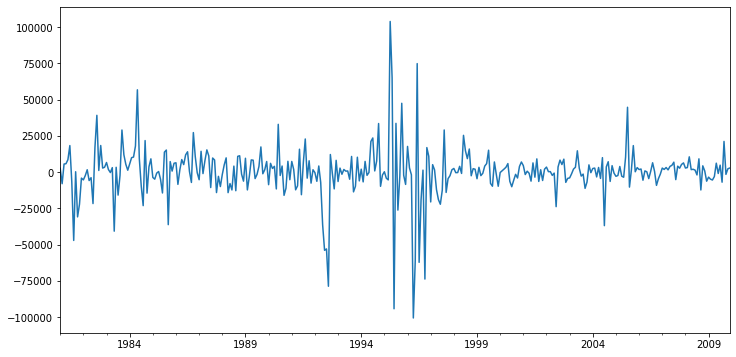

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,82.211077,1.560167e-12,79.641411,4.831046e-12


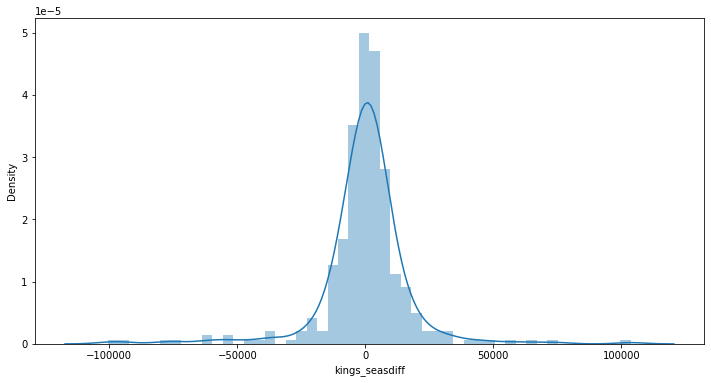

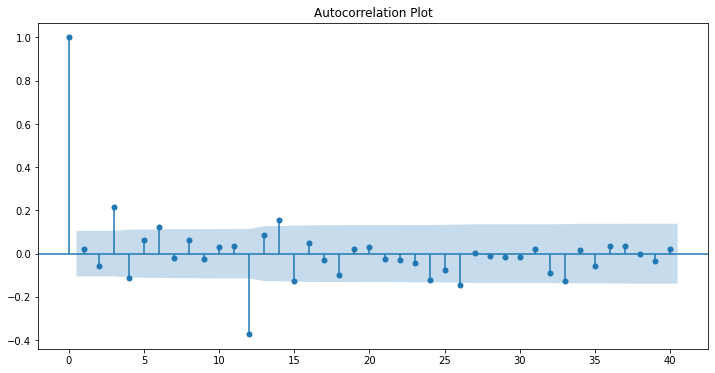

In [117]:
resid = pd.Series(varmax_model_fit.resid['kings_seasdiff'], index = y_train.index)
resid = resid[12:]
examine_resid(resid)

### Convert predicted values back to their original units (done outside of Python)

In [ ]:
yhat = varmax_model_fit.forecast(exog=y_test[['gasoline_seasdiff','temp_seasdiff']], steps=len(y_test))
df_preds = pd.concat([y_train[-12:],yhat], axis=0).reset_index(drop=True)
df_preds.to_csv("df_preds.csv")

In [121]:
df_preds_adj = pd.read_csv("df_preds_adj.csv")
df_preds_adj.index = pd.date_range(min(y_test.ds), max(y_test.ds), freq = "MS")
final_results = pd.concat([y_test[["yosemite","sequoia","kings"]],df_preds_adj], axis=1)

### VARMAX prediction results

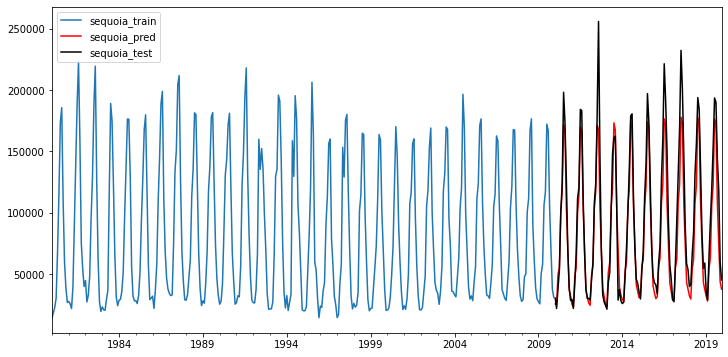

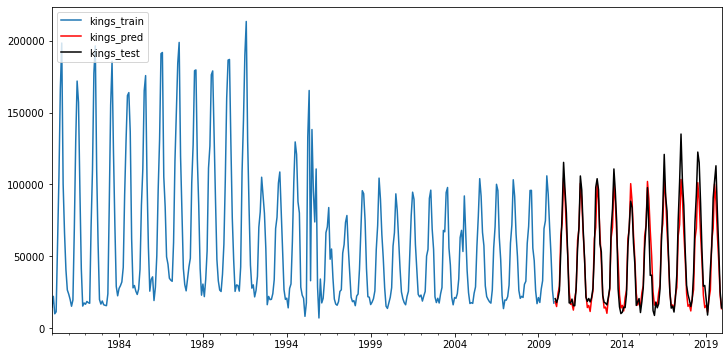

In [122]:
plt.figure(figsize=[12,6])
y_train.sequoia.plot()
final_results.sequoia_pred.plot(color="red")
final_results.sequoia.plot(color="black")
plt.legend(["sequoia_train", "sequoia_pred", "sequoia_test"], loc = "upper left")
plt.show()

plt.figure(figsize=[12,6])
y_train.kings.plot()
final_results.kings_pred.plot(color="red")
final_results.kings.plot(color="black")
plt.legend(["kings_train", "kings_pred", "kings_test"], loc = "upper left")
plt.show()

In [123]:
model_eval(y_train["sequoia"], y_test["sequoia"], df_preds_adj.sequoia_pred)

mae: 13368.904787916666
mse: 373374304.0173267
mape: 14.640083000886959
smape: 0.1530515864832759
mase: 0.4912586457707883


In [124]:
model_eval(y_train["kings"], y_test["kings"], df_preds_adj.kings_pred)

mae: 7596.9981214166655
mse: 109686170.09676473
mape: 18.81577719770724
smape: 0.18257421083887504
mase: 0.36007929595833144


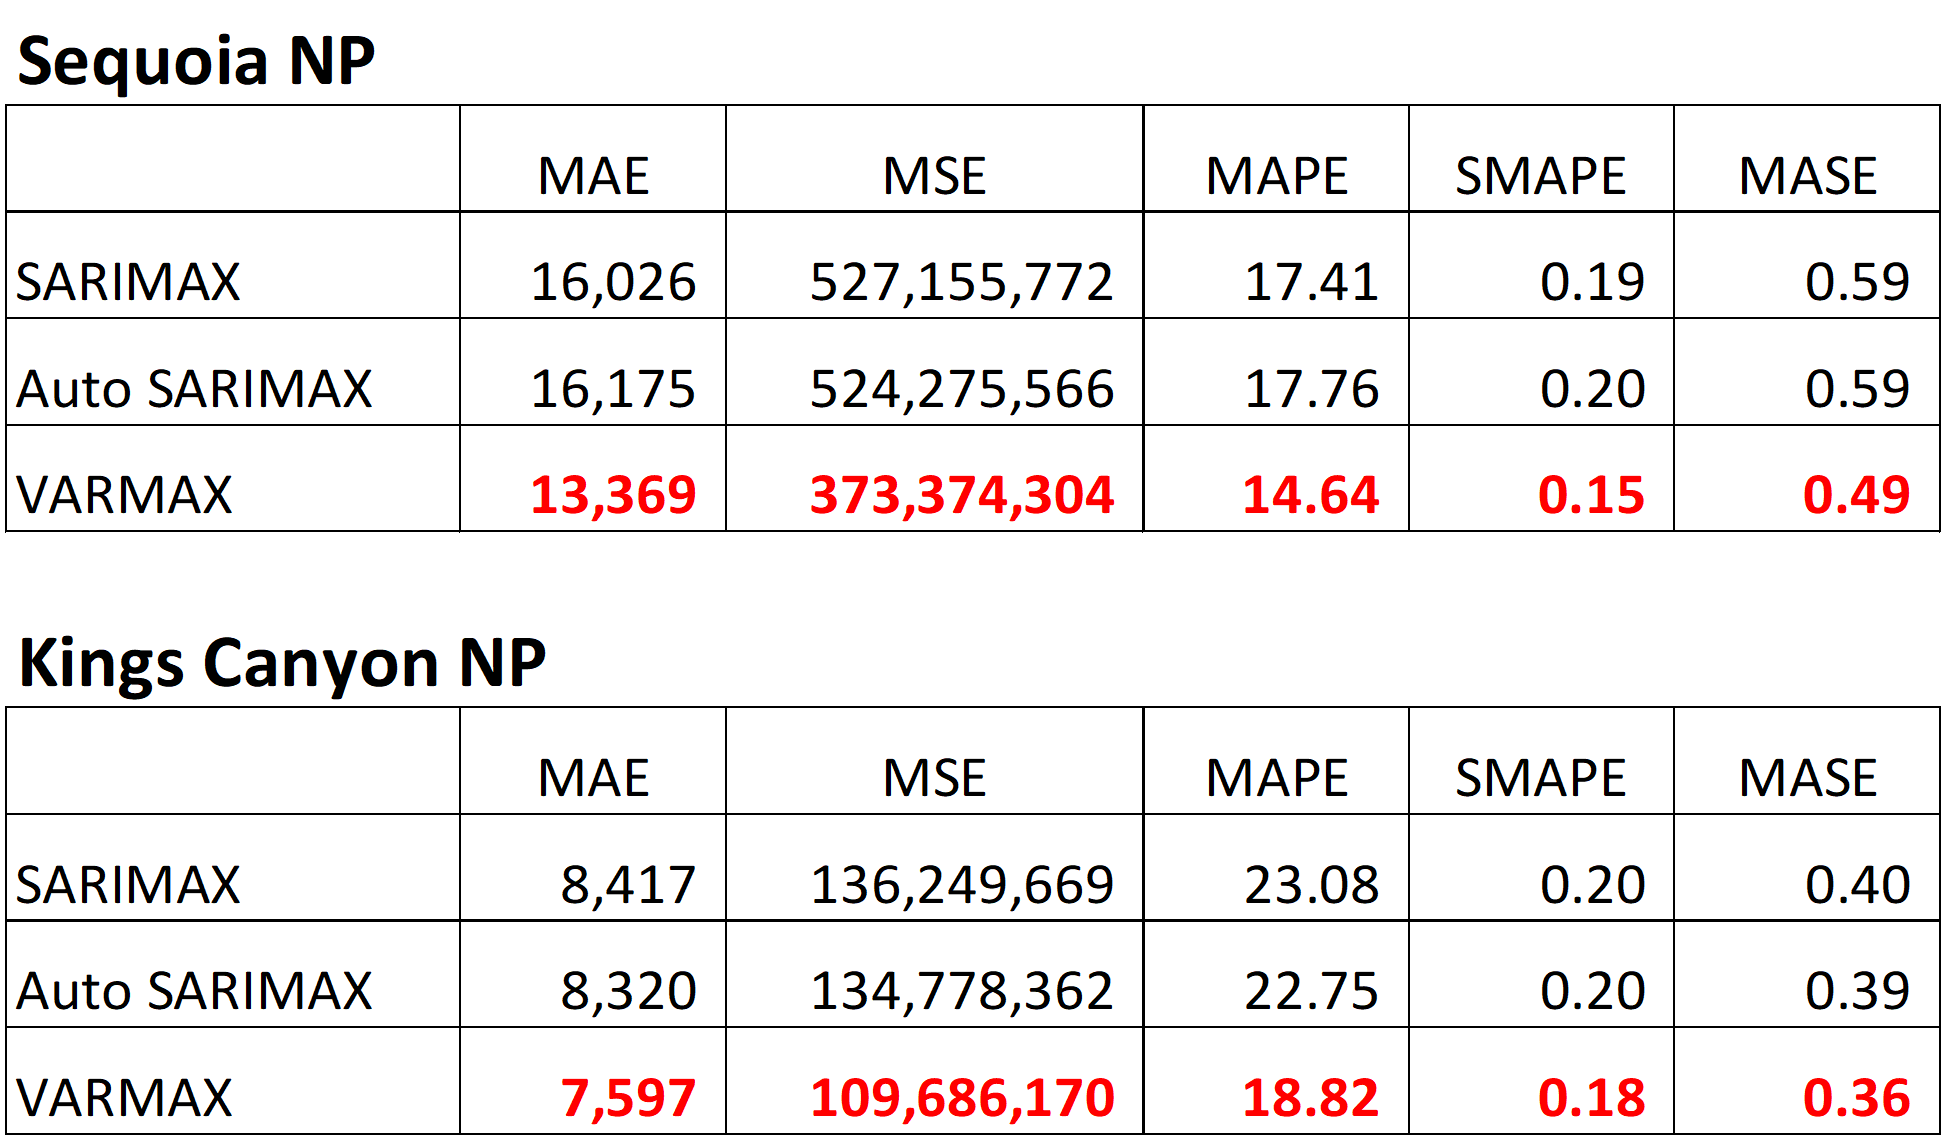

In [127]:
from PIL import Image
Image.open('performance.emf')